In [1]:
from abtem import GridScan, PixelatedDetector, PotentialArray, Probe
from abtem.reconstruct import epie
from abtem.transfer import CTF, scherzer_defocus
from abtem.detect import FlexibleAnnularDetector

import numpy as np
import matplotlib.pyplot as plt
import tifffile
import tkinter.filedialog as tkf

In [2]:
modulus = plt.imread("data/modulus.jpg")
modulus = modulus[:, :, 0]
modulus = np.reshape(modulus, modulus.shape[:2])
print(modulus.shape)

phase = plt.imread("data/phase.jpg")
phase = phase[:, :, 0]
phase = np.reshape(phase, phase.shape[:2])
print(phase.shape)

(256, 256)
(256, 256)


In [3]:
modulus = modulus / np.max(modulus)
phase = phase / np.max(phase)
phase = phase - 0.5
phase = phase * 2 * np.pi
print(modulus.min(), modulus.max())
print(phase.min(), phase.max())

0.0 1.0
-3.141592653589793 3.141592653589793


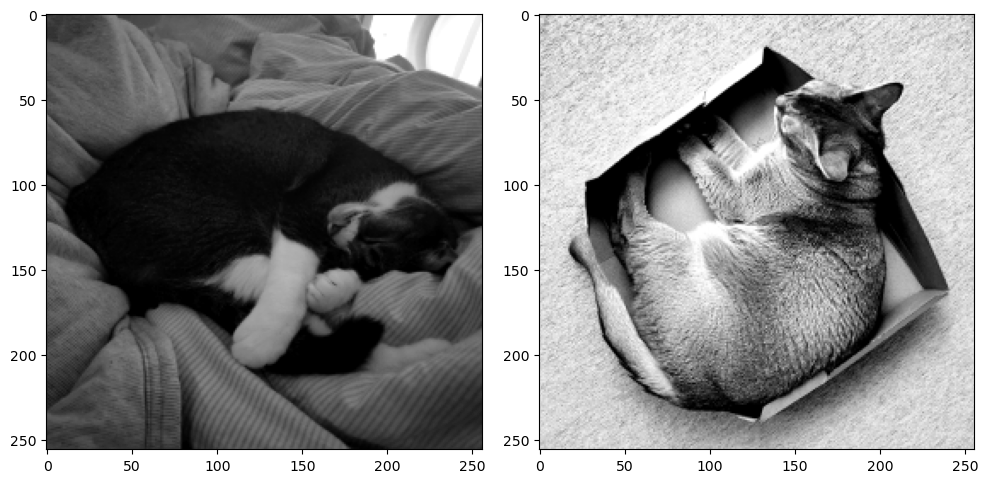

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(modulus, cmap="gray")
ax[1].imshow(phase, cmap="gray")
fig.tight_layout()
plt.show()

In [5]:
WPO = np.zeros(modulus.shape, dtype=np.complex64)
WPO.real = modulus * np.cos(phase)
WPO.imag = modulus * np.sin(phase)
print(WPO.shape)

(256, 256)


In [6]:
potential = PotentialArray(np.flip(WPO.T, axis=1)[None], [0.], sampling=0.1)
sph_abr = 1E6

probe = Probe(semiangle_cutoff=30, energy=80e3, Cs=sph_abr) # Cs 0.1 mm
probe.grid.match(potential)

sch_defocus = scherzer_defocus(sph_abr, probe.energy)
print(sch_defocus)

250.27133444991352


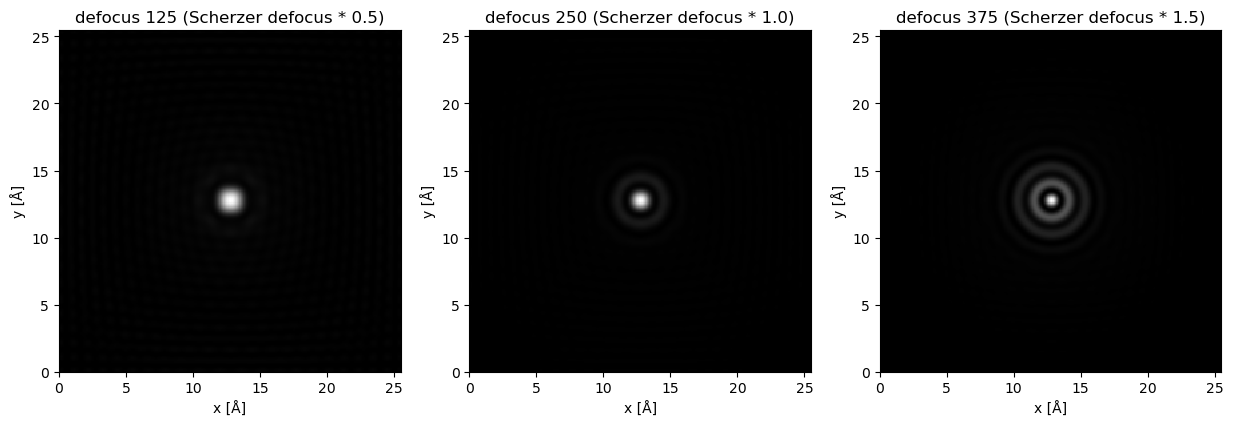

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
defs = [0.5, 1.0, 1.5]
for i, r in enumerate(defs):
    probe.ctf.defocus = r*sch_defocus
    probe.show(ax=axes[i], title="defocus %d (Scherzer defocus * %.1f)"%(r*sch_defocus, r))
plt.show()

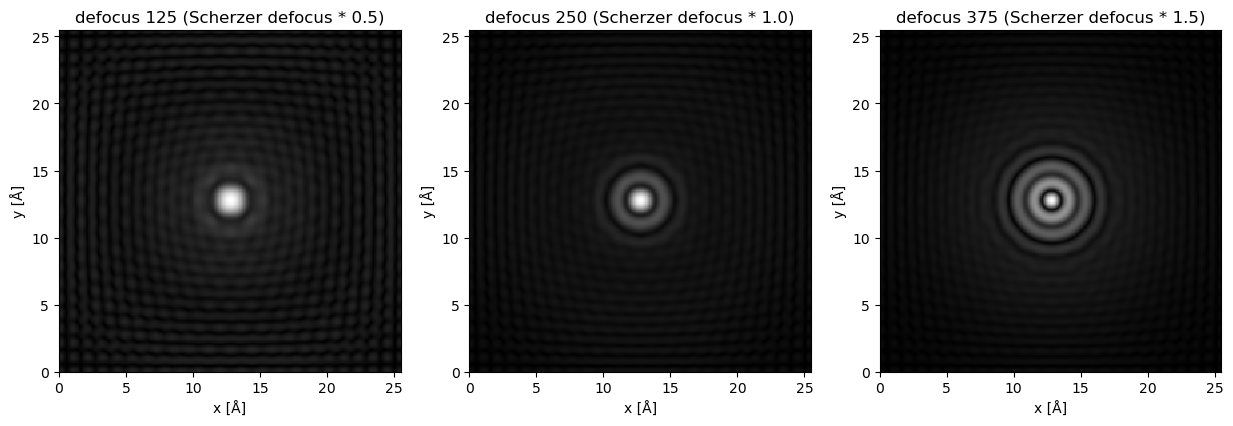

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
defs = [0.5, 1.0, 1.5]
for i, r in enumerate(defs):
    probe.ctf.defocus = r*sch_defocus
    probe.show(ax=axes[i], title="defocus %d (Scherzer defocus * %.1f)"%(r*sch_defocus, r), power=0.5)
plt.show()

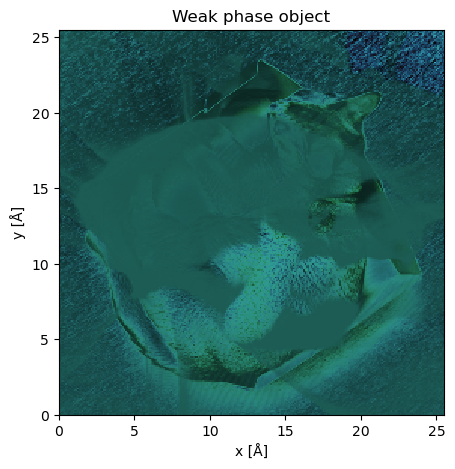

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))
potential.project().show(ax=ax1, title='Weak phase object')
plt.show()

In [9]:
print("Nyquist sampling", probe.ctf.nyquist_sampling)

Nyquist sampling 0.34797633804078043


In [10]:
gridscan = GridScan((0,0), potential.extent, sampling=0.5)
detector = PixelatedDetector(None)
probe.ctf.defocus = 0.5*sch_defocus
flexible_measurement1 = probe.scan(gridscan, FlexibleAnnularDetector(step_size=10), potential)
measurement1 = probe.scan(gridscan, [detector], potential)

Scan:   0%|          | 0/2601 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Scan:   0%|          | 0/2601 [00:00<?, ?it/s]

(51, 51, 256, 256)


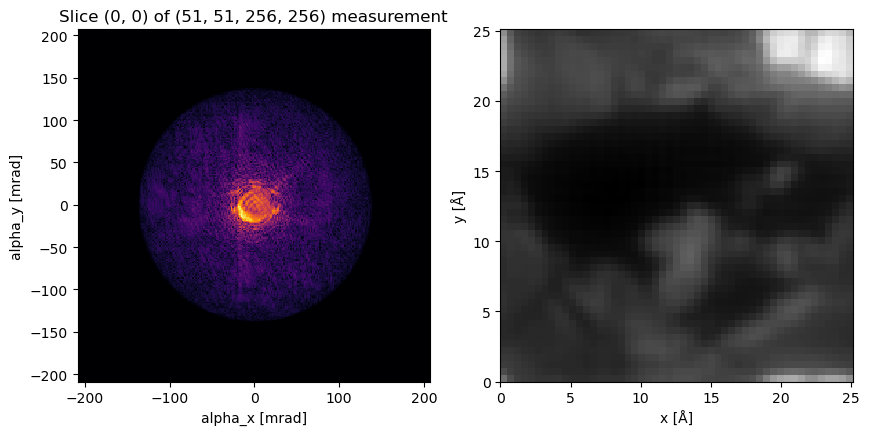

In [11]:
print(measurement1.shape)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
measurement1.show(ax=axes[0], cmap="inferno", power=0.25)
flexible_measurement1.integrate(10, 30).show(ax=axes[1], cmap="gray")
plt.show()

In [12]:
probe.ctf.defocus = sch_defocus
flexible_measurement2 = probe.scan(gridscan, FlexibleAnnularDetector(step_size=10), potential)
measurement2 = probe.scan(gridscan, [detector], potential)

Scan:   0%|          | 0/2601 [00:00<?, ?it/s]

Scan:   0%|          | 0/2601 [00:00<?, ?it/s]

(51, 51, 256, 256)


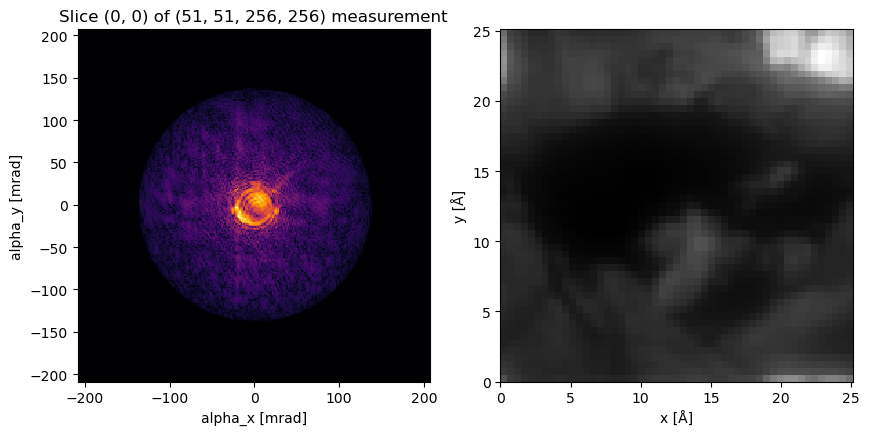

In [13]:
print(measurement1.shape)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
measurement2.show(ax=axes[0], cmap="inferno", power=0.25)
flexible_measurement2.integrate(10, 30).show(ax=axes[1], cmap="gray")
plt.show()

In [14]:
probe_guess = Probe(semiangle_cutoff=30, energy=80e3)

In [20]:
reconstructions1 = epie(measurement1, probe_guess, maxiter=30, return_iterations=True, fix_com=True, device='gpu')

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/2601 [00:00<?, ?it/s]

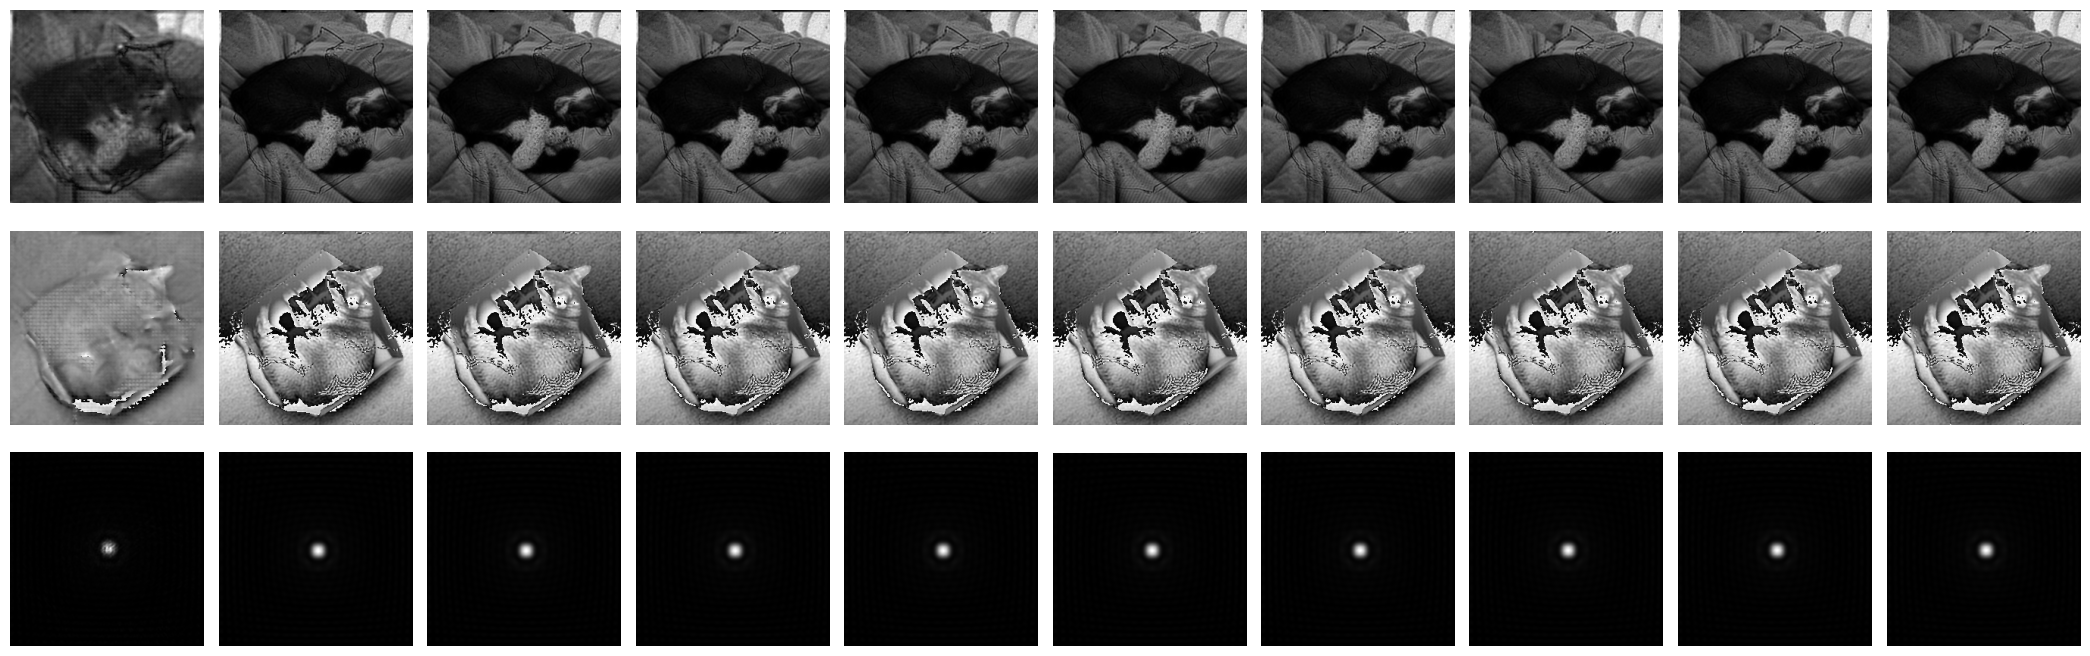

In [21]:
plot_every = 3

fig, axes = plt.subplots(3, int(np.ceil(len(reconstructions[0]) / plot_every)), figsize=(21, 7))

for i, j in enumerate(range(0,len(reconstructions[0]),plot_every)):
    modulus_tmp = np.abs(reconstructions1[0][j].array).T
    phase_tmp = np.angle(reconstructions1[0][j].array).T
    probe_tmp = np.abs(reconstructions1[1][j].array)
    axes[0,i].imshow(modulus_tmp, origin='lower', cmap='gray')
    axes[1,i].imshow(phase_tmp, origin='lower', cmap='gray')
    axes[2,i].imshow(probe_tmp.T ** 2, origin='lower', cmap='gray')
    
    for ax in (axes[0,i], axes[1,i], axes[2,i]):
        ax.axis('off')
fig.tight_layout()
plt.show()

In [26]:
reconstructions2 = epie(measurement2, probe_guess, maxiter=30, return_iterations=True, fix_com=True, device='gpu')

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/2601 [00:00<?, ?it/s]

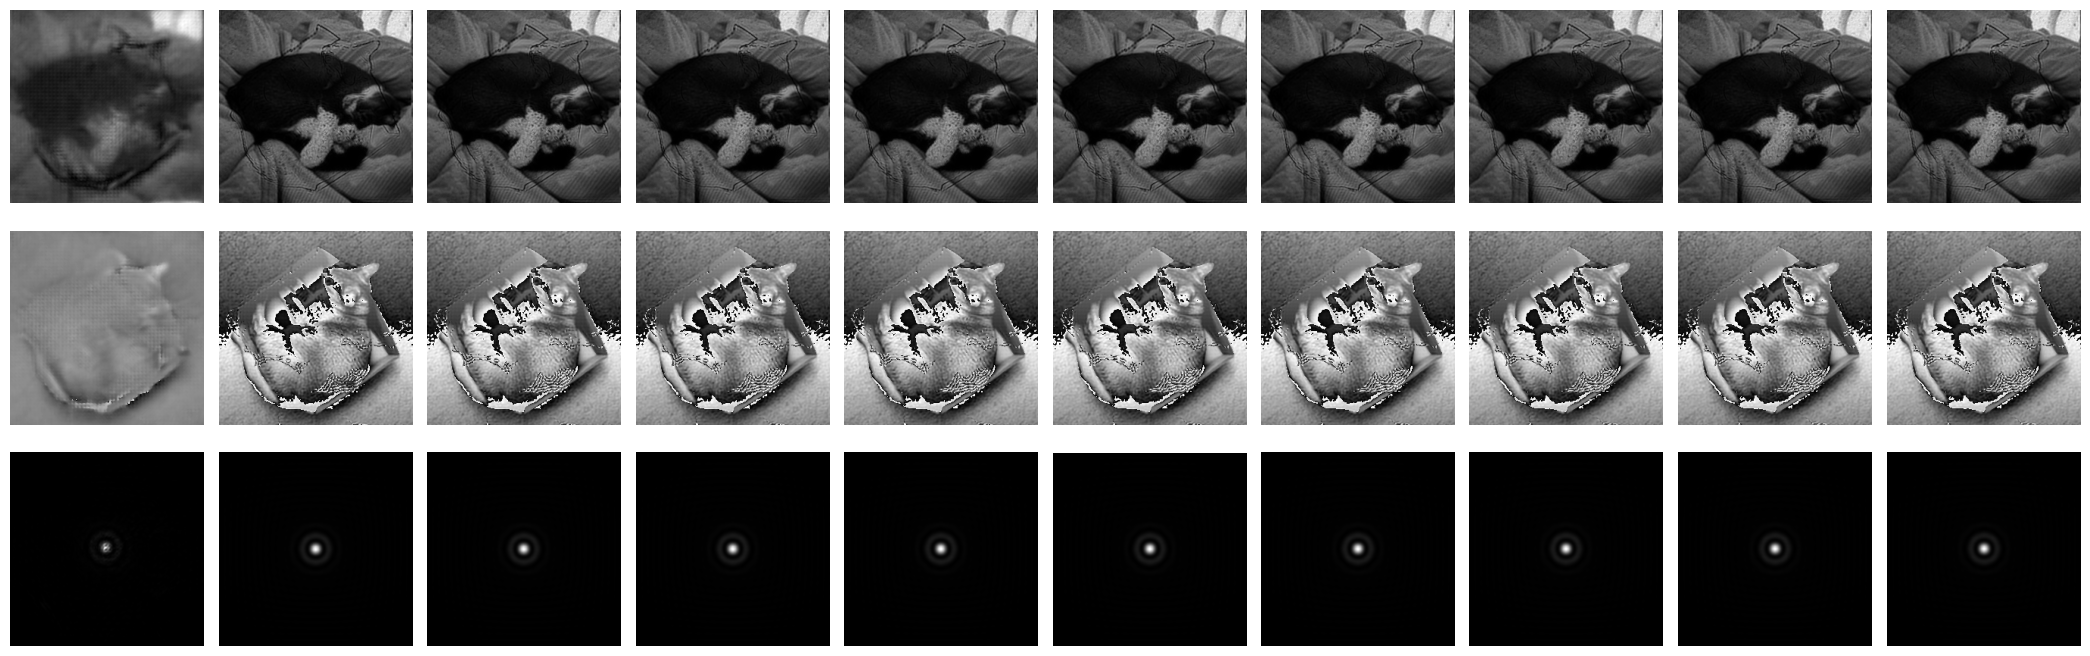

In [27]:
plot_every = 3

fig, axes = plt.subplots(3, int(np.ceil(len(reconstructions[0]) / plot_every)), figsize=(21, 7))

for i, j in enumerate(range(0,len(reconstructions[0]),plot_every)):
    modulus_tmp = np.abs(reconstructions2[0][j].array).T
    phase_tmp = np.angle(reconstructions2[0][j].array).T
    probe_tmp = np.abs(reconstructions2[1][j].array)
    axes[0,i].imshow(modulus_tmp, origin='lower', cmap='gray')
    axes[1,i].imshow(phase_tmp, origin='lower', cmap='gray')
    axes[2,i].imshow(probe_tmp.T ** 2, origin='lower', cmap='gray')
    
    for ax in (axes[0,i], axes[1,i], axes[2,i]):
        ax.axis('off')
fig.tight_layout()
plt.show()